# Deepcamp: Codelab 3
---
**In this tutorial we will cover**:

- Pytorch: a Deep learning framework
- Fine-tuning a pretrained Neural Network on a 
- Using a Web service for fine-tuning


**Author**:
- Alessio Devoto (alessio.devoto@uniroma1.it)


**Duration**: 50 mins 


**Warning**: Make sure your colab has the GPU option enabled!

# German Traffic Sign Recognition Benchmark 
---
We want to train a **deep learning** model to classify photos of traffic signs.

We will put our hands on our first neural network 🙂, thus officially entering the world of deep learning (so far we only used simple ML models).

What are we going to do? 🤔

1. Data import & preprocessing 💾
2. Download of a pretrained neural network
3. Fine-tuning & evaluation of the neural network 📉

We first import the necessary libraries as usual

In [1]:
import torch
from torch.nn import Linear
import torchvision
from torchvision.datasets import GTSRB 

## 1. Data import and preprocessing
There is plenty of [torchvision datasets](https://pytorch.org/vision/stable/datasets.html) to use off-the-shelf if you ever want to try yourself.

### 1.1 Data import: torchvision datasets
In this case, we can leverage torchvision's built-in dataset collection. The `torchvision.datasets` modules makes several famouse datasets available. 

For this noteook we will use the [German Traffic Sign Recognition Benchmark](https://paperswithcode.com/dataset/gtsrb), which contains photos of 43 different traffic signs, taken from Germany's streets.

We can usually pick between train and validation set via some flags.


In [2]:
trainset = GTSRB(root='./data', split='train', download=True, transform=None) # only download train split
testset = GTSRB(root='./data', split='test', download=True, transform=None)   # only download test split

image, label = trainset[0]
# image will be the input datum to our model
# label is the class corresponding to that image

100%|██████████| 187490228/187490228 [00:19<00:00, 9814765.44it/s] 


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


100%|██████████| 88978620/88978620 [00:09<00:00, 8937439.59it/s] 


Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 123619.37it/s]

Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb


In [3]:
# this is a <PIL Image>
# PIL is a Python library for imaging
# we can easily take a look at an image like this 
image.show()

In [4]:
# the class corresponding to this image
label

0

We have 43 different classes in this dataset ➡ we should train our model on 43 possible labels. Unfortunately, this would be too much for our poor free Colab GPU 😢. 

Training models **requires good hardware** (usually GPUs or TPUs). The better the hardware, the faster you can train your neural network. If your model is too large, chances are it will not even fit your GPUs.

This is why often only big tech companies can afford to train big models, investing millions of dollars in the training process. 💸

This said, we will shrink our dataset to make the training faster.
Let us create new datasets that contain only 3 of the initial 43 classes.

In [ ]:
"""labels_to_keep = {0,1,2}
keep_train_idx = [idx for idx, elem in enumerate(trainset) if elem[1] in labels_to_keep]
keep_test_idx = [idx for idx, elem in enumerate(testset) if elem[1] in labels_to_keep]

trainset = torch.utils.data.Subset(trainset, keep_train_idx)
testset = torch.utils.data.Subset(trainset, keep_test_idx)"""


### 1.1.1 (Optional) Additional info on Pytorch datasets
You can easily create a custom Pytorch dataset with (almost) any kind of data.

[`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__len__`: so that `len(dataset)` returns the size of the dataset
- `__getitem__`: so that `dataset[i]` returns the $i$-th sample from the dataset.

In [ ]:
from torch.utils.data import Dataset

class ToyDataset(Dataset):

  def __init__(self, n_points: int = 20, noise: float = .1):
    super().__init__()  # In python 3 this is enough

    self.n_points = n_points
    self.x = torch.linspace(-1, 1, n_points)      # a space with n points
    self.y = self.x ** 3 + noise * torch.randn(n_points)

  def __len__(self):
    return self.n_points

  def __getitem__(self, idx):
    return {
        'x': self.x[idx],
        'y': self.y[idx]
    }

toydataset = ToyDataset(20, noise=.1)
toydataset[5]

### 1.1 Transforms

Images (and data in general) don't usually go from the dataset straight to the model: they need some manipulation first (just like we saw in the previous notebooks). 

Luckily, Pytorch provides `torchvision.transforms`!
`transforms` are a powerful concept that allows us to preprocess each sample in the dataset right after it is retrieved. 

They come in a lot of different flavors and can be used for a variety of tasks, like resizing images or performing [data augmentation](https://d2l.ai/chapter_computer-vision/image-augmentation.html).

---

Here is an example of a transformed image:

![transforms](https://pytorch.org/vision/0.11/_images/sphx_glr_plot_transforms_thumb.png)

Thanks to the `Resize` transform, we can resize the image to a bigger format and have a better look at it

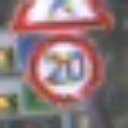

In [6]:
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, ToPILImage

# args are the new width and height
resize = Resize((128,128))
resize(image).show()

You can combine transforms using `transforms.Compose`. 
You have a lot of options found in [torchvision.transforms.](https://pytorch.org/vision/stable/transforms.html)

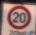

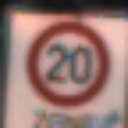

In [10]:
# Exercise: Apply a sequence of transforms a random image in the dataset and display it

im = trainset[100][0]
im.show()

transformed_image = Compose([torchvision.transforms.RandomHorizontalFlip(), Resize((128,128))])(im)
transformed_image.show()

Which transforms are we going to use for our task?
In general, it is advised to use some data augmentation to help the model avoid overfitting. 

In our case, to keep things simple (and fast) we just resize the image to a standard 32x32 and do some normalization, for the same reasons of the previous notebooks.


In [23]:
# Our final transform will look like this
transform = Compose(
    [
    ToTensor(),
    Resize((32,32)),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

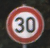

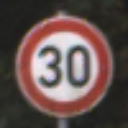

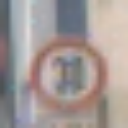

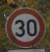

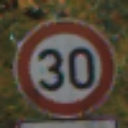

In [15]:
#@title Exercise 🏋 : Compose transforms and show results

# write a for loop that takes five random images of the dataset, applies a random transform, and shows the results before and after



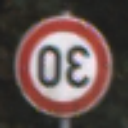

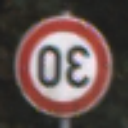

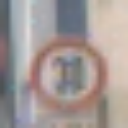

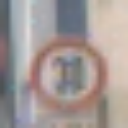

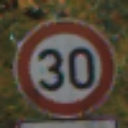

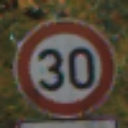

In [22]:
#@title Peek 👀 solution 

my_transform = Compose([torchvision.transforms.RandomHorizontalFlip(), Resize((128,128))])

for i in range(0,300,100):
  img = trainset[500+i][0]
  img.show()
  t_img = my_transform(img)
  t_img.show()

If you created a loop like:

```
for i in range(0,5):
  do stuff
```

you probably got all images of the same class. This is because the dataset is * sorted according to the class* and we did not **shuffle** it. 

*Shuffling the dataset is crucial for the network to learn properly.* Forgetting to shuffle a sorted dataset can result in [catastrophic fortgetting](https://en.wikipedia.org/wiki/Catastrophic_interference#:~:text=Catastrophic%20interference%2C%20also%20known%20as,information%20upon%20learning%20new%20information.). 

Luckily, the `torchvision.dataloader` will provide some features to shuffle our dataset.


### 1.2 Preprocessing and dataloaders

[`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) is an iterator which provides:

- Data batching ➡ get samples from data in batches instead of one-by-one
- Data shuffling ➡ mix the data
- Parallel data loading using `multiprocessing` workers ➡ while the `GPU` is performing some computation on a batch, in parallel you can load the next batch.


Creating a dataloader from a dataset is straightforward, this is one example that highlights some of the most used parameters:

In [24]:
batch_size = 4 

trainset = GTSRB(root='./data', split='train', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = GTSRB(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



In [27]:
next(iter(trainloader))[0].shape

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

torch.Size([4, 3, 32, 32])

## 2. Training 🏃: Hands on ResNet-18

Let us have a look at how we can build and train a Neural Network.

### 2.1 Building blocks of Neural Networks

In Pytorch you can build your own neural networks with custom architectures by using the `nn.Module` class. 

- You can combine different `nn.Module`s into your custom block, which should just implement the `forward` function. 
- Pytorch will take care of the differentiation in the training process.
- A list of pre-implemented layers is found at [pytorch nn modules](https://pytorch.org/docs/stable/nn.html#convolution-layers)



A simple `nn.Linear` performs a matrix multiplication:

![linear](https://www.sharetechnote.com/image/Python_Pytorch_nn_Linear_i2_o3_01.png)

In [ ]:
from torch.nn import Linear
import torch

# define a linear layer which accepts inputs of dimension 10 and produces outputs of dimension 100
linear_layer = Linear(in_features=10, out_features=100)

# random input batch with 30 samples
input_sample = torch.randn(30,10)

# this is calling the linear layer forward
output = linear_layer(input_sample)
output.shape

torch.Size([30, 100])

Just so we have an idea, this is what a vanilla CNN would look like in Pytorch.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Unfortunately, we don't have time for implementing and training a decent CNN here...

Good news though: Pytorch gives us the chance to download pre-designed and in some cases even pre-trained architectures. 

### 2.2 Pre-trained models 
In [torchvision](https://pytorch.org/vision/stable/models.html) you can find a variety of pre-implemented model architectures. 
For a lot of such architectures, you can also downaload the weights of a pretrained model.

Let us download the pre-trained version of ResNet-18, a very famous Convolutional Neural Network. 
This net was trained on thousands of data already, so we expect it to be quite good at a variety of tasks.

In [ ]:
from torchvision.models import resnet18

res = resnet18(weights=True)


/Users/alessiodevoto/opt/anaconda3/envs/torch-cl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Let us have a look at ResNet under the hood

In [ ]:
res

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Cool! The model is composed by a number of blocks and a final fully connected layer, that had 1000 output neurons... 

Our dataset only had 47 classes though! What shall we do? 
We can simplt replace the fully connected linear layer with a new (randomly initialized one).

In [ ]:
# in case we want to freeze the feature extractor
for param_name, param in res.named_parameters():
    param.requires_grad = False

In [ ]:
# Exercise: replace the last fully connected layer of the network with a linear layer
# Hint: the linear layer must have the same number of input neurons but a only 47 output neurons

res.fc = Linear(512, 47)

### 2.3 Training

The training process of a neural network can be long and even expesive in terms of energy and time required. 

Based on the hardware you have, it can take a lot to train even small models. This is the reason why a lot of the "big-tech" companies invest a lot of capital for buying GPUs. 


The general scheme for the training is usually the following:

IMAGE of training

Because this would take some time to code, we make use of a library which makes the training easier, by managing the whole training and validation routing in a transparent way.

Pytorch-Lightning makes the training more efficient and just requires us to define what the network should do in the training and validation steps.

In [ ]:
from pytorch_lightning import LightningModule, Trainer
from torch.nn.functional import cross_entropy
from torchmetrics import Accuracy

class LightningResNet(LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model


    def forward(self, x):
        return self.model(x)
    

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=1e-3)
        return optimizer


    def training_step(self, train_batch, batch_idx):
        image, label = train_batch
        prediction = self.model(image)
        loss = cross_entropy(prediction, label)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        image, label = val_batch
        prediction = self.model(image)
        loss = cross_entropy(prediction, label)
        self.log('val_loss', loss)

        accuracy = Accuracy('multiclass', num_classes=47)
        acc = accuracy(prediction, label)
        self.log('accuracy', acc, on_epoch=True)
    
    def test_step(self, val_batch, batch_idx):
        image, label = val_batch
        prediction = self.model(image)
        loss = cross_entropy(prediction, label)
        self.log('val_loss', loss)

        accuracy = Accuracy('multiclass', num_classes=47)
        acc = accuracy(prediction, label)
        self.log('accuracy', acc, on_epoch=True)

lit_resnet = LightningResNet(res)


In [ ]:
trainer = Trainer(accelerator='cpu', max_epochs=1) # change accelerator to gpu # max_time="00:00:02:00"
trainer.fit(lit_resnet, train_dataloaders=trainloader, val_dataloaders=testloader) 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
24.1 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.802    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 6660/6660 [05:18<00:00, 20.93it/s, v_num=1]      

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 6660/6660 [05:18<00:00, 20.92it/s, v_num=1]


In [ ]:
trainer.test(lit_resnet,dataloaders=testloader)

MisconfigurationException: No `test_step()` method defined to run `Trainer.test`.